<a href="https://colab.research.google.com/github/safdarjung/saf/blob/main/Neural_Network_From_Scratch_numpy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import cupy as cp  # CuPy for GPU-accelerated array computations
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


def one_hot_encode(Y, num_classes):
    m = Y.shape[0]  # Number of examples
    one_hot = cp.zeros((m, num_classes))
    one_hot[cp.arange(m), Y] = 1  # one hot encode the labes for each row
    return one_hot

mnist = fetch_openml('mnist_784', version=1)

# Normalize the image data to [0, 1] and convert types.
X = mnist.data.astype(np.float32) / 255.0
Y = mnist.target.astype(np.int32)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# --- Data Conversion for GPU ---
# Transpose so that each column represents one example.
# Then convert the NumPy arrays to CuPy arrays for GPU computations.
X_train = cp.array(X_train.T)
X_test = cp.array(X_test.T)
Y_train = cp.array(Y_train)
Y_test = cp.array(Y_test)

# One-hot encode the labels and then transpose.
Y_train_enc = one_hot_encode(Y_train, 10).T
Y_test_enc = one_hot_encode(Y_test, 10).T





In [9]:

def sigmoid(Z):
    return 1 / (1 + cp.exp(-Z))

def sigmoid_derivative(Z):
    s = sigmoid(Z)
    return s * (1 - s)

def softmax(Z):
    # Subtract the max value for numerical stability.
    expZ = cp.exp(Z - cp.max(Z, axis=0, keepdims=True))
    return expZ / cp.sum(expZ, axis=0, keepdims=True)


def initialize_parameters(n_x, n_h, n_y):
    cp.random.seed(42)
    W1 = cp.random.randn(n_h, n_x) * 0.01  # Small random weights for layer 1
    b1 = cp.zeros((n_h, 1))  # Zero biases for layer 1
    W2 = cp.random.randn(n_y, n_h) * 0.01  # Small random weights for layer 2
    b2 = cp.zeros((n_y, 1))  # Zero biases for layer 2
    return {"W1": W1, "b1": b1, "W2": W2, "b2": b2}


def compute_cost(A2, Y):
    m = Y.shape[1]  # Number of examples
    cost = -cp.sum(Y * cp.log(A2)) / m  # Average cross-entropy loss
    return cost


In [10]:

def forward_propagation(X, parameters):
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]

    # hidden layer linear combination.
    Z1 = cp.dot(W1, X) + b1
    A1 = sigmoid(Z1)
    # Compute output layer linear combination.
    Z2 = cp.dot(W2, A1) + b2
    # Apply softmax to obtain class probabilities.
    A2 = softmax(Z2)

    # Cache results for use in backpropagation.
    cache = {"Z1": Z1, "A1": A1, "Z2": Z2, "A2": A2}
    return A2, cache


In [11]:

def backward_propagation(parameters, cache, X, Y):
    m = X.shape[1]  # Number of examples
    W2 = parameters["W2"]
    A1 = cache["A1"]
    A2 = cache["A2"]

    # Gradient of cost with respect to Z2.
    dZ2 = A2 - Y
    # Gradients for weights and biases of the second layer.
    # we dot the loss (last layer after fwd_prop - actual labels) with the previous input to the layer before the final layer A1.
    # eg: W4 will be updated  W5.T . Z4, and dW4 and db4 by using the output after the activation lyer in the previous layer
    dW2 = cp.dot(dZ2, A1.T) / m
    db2 = cp.sum(dZ2, axis=1, keepdims=True) / m    #produces a column vector where each element corresponds to the total error for one neuron across all training examples.

    # Backpropagate to the hidden layer.
    dZ1 = cp.dot(W2.T, dZ2) * sigmoid_derivative(cache["Z1"])
    dW1 = cp.dot(dZ1, X.T) / m
    db1 = cp.sum(dZ1, axis=1, keepdims=True) / m

    gradients = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}
    return gradients


def update_parameters(parameters, gradients, learning_rate):
    parameters["W1"] = parameters["W1"] - learning_rate * gradients["dW1"]
    parameters["b1"] = parameters["b1"] - learning_rate * gradients["db1"]
    parameters["W2"] = parameters["W2"] - learning_rate * gradients["dW2"]
    parameters["b2"] = parameters["b2"] - learning_rate * gradients["db2"]
    return parameters


In [12]:

def nn_model(X, Y, n_h, num_iterations, learning_rate, print_cost=False):
    n_x = X.shape[0]  # Number of input features
    n_y = Y.shape[0]  # Number of output classes
    parameters = initialize_parameters(n_x, n_h, n_y)

    for i in range(num_iterations):
        # Forward propagation: compute output probabilities.
        A2, cache = forward_propagation(X, parameters)
        # Compute the cross-entropy cost.
        cost = compute_cost(A2, Y)
        # Backward propagation: compute gradients.
        gradients = backward_propagation(parameters, cache, X, Y)
        # Update parameters using gradient descent.
        parameters = update_parameters(parameters, gradients, learning_rate)

        # Print cost every 100 iterations (cost is moved back to CPU for printing).
        if print_cost and i % 100 == 0:
            print("Cost after iteration %i: %f" % (i, cp.asnumpy(cost)))
    return parameters



def predict(parameters, X):
    A2, _ = forward_propagation(X, parameters)
    predictions = cp.argmax(A2, axis=0)  # Class with the highest probability
    return predictions



Cost after iteration 0: 2.302615
Cost after iteration 100: 0.974716
Cost after iteration 200: 0.513692
Cost after iteration 300: 0.397578
Cost after iteration 400: 0.346553
Cost after iteration 500: 0.316647
Cost after iteration 600: 0.295687
Cost after iteration 700: 0.279393
Cost after iteration 800: 0.265900
Cost after iteration 900: 0.254255
Training accuracy:  93.025
Test accuracy:  92.75714285714287


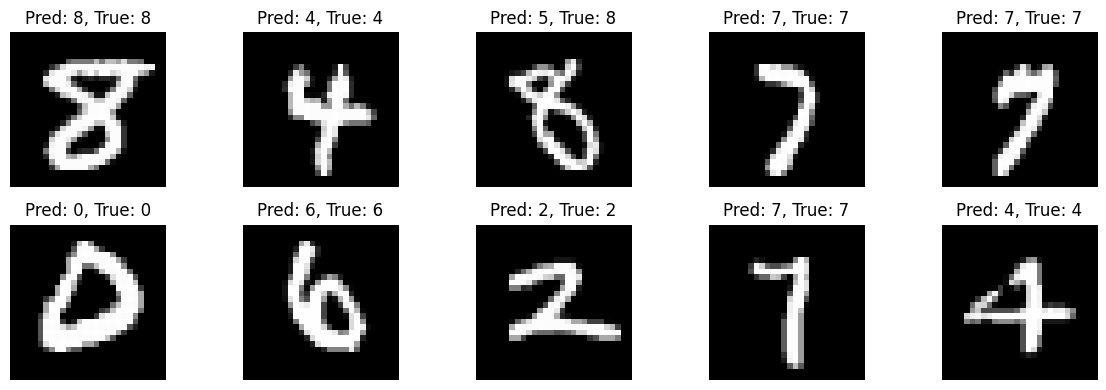

In [13]:

n_h = 64              # Number of hidden units
num_iterations = 1000 # Number of training iterations
learning_rate = 0.5   # Learning rate

# Train the neural network model on the training set using GPU.
parameters = nn_model(X_train, Y_train_enc, n_h, num_iterations, learning_rate, print_cost=True)

# Generate predictions on training and test sets.
train_predictions = predict(parameters, X_train)
test_predictions = predict(parameters, X_test)

# Compute accuracy (transfer results from GPU to CPU for printing).
train_accuracy = cp.mean(train_predictions == Y_train) * 100
test_accuracy = cp.mean(test_predictions == Y_test) * 100

print("Training accuracy: ", cp.asnumpy(train_accuracy))
print("Test accuracy: ", cp.asnumpy(test_accuracy))

# ------------------------- Visualization of Test Outputs -------------------------

# Transfer test predictions and test images back to CPU (NumPy) for visualization.
test_preds_cpu = cp.asnumpy(test_predictions)
X_test_cpu = cp.asnumpy(X_test)  # Shape: (784, number of test examples)
Y_test_cpu = cp.asnumpy(Y_test)

# Plot the first 10 test images with their predicted and true labels.
plt.figure(figsize=(12, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    # Reshape the flat 784-length vector into a 28x28 image.
    image = X_test_cpu[:, i].reshape(28, 28)
    plt.imshow(image, cmap='gray')
    plt.title("Pred: %d, True: %d" % (test_preds_cpu[i], Y_test_cpu[i]))
    plt.axis('off')
plt.tight_layout()
plt.show()